In [1]:
%%html
<link rel= "stylesheet" type= "text/css" href= "style.css">

# <div class = "title">Pràctica 2 <br> Classificació, detecció i Segmentació al Caltech </div>
## <div class = "sub-title">Segona pràctica d'Aprenentatge automàtic amb xarxes neuronals</div>
### <div class = "subsub-title">Aprenentatge automàtic 2024-25</div>

<div style="text-align: center;">
    <img src="img/portada2.png" align="justify" width="65%" class="border"/>
    
    Antoni Frau Gordiola - 43482642S
    Miquel Oliver Alcayde - 43482642S
</div>

## Funcions auxiliars

<p>El primer de tot són les funcions i <em>imports</em> que ens ajudaran a llegir les dades i anotacions, tractar-les si fa falta, visualitzats, etc. També si en algun moment s'usa una funció auxiliar, es trobarà aquí. Part d'aquesta secció ha estat proporcionada pels professors i material docent.</p>

In [63]:
import os
import numpy as np
import random
import imageio.v2 as imageio
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# ---
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score

from PIL import Image

In [98]:
# GENERAR DATA AUGMENTATION Y GUARDAR

# Transformacions
data_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=None, shear=None), #Translació en vertical i horitzontal
    transforms.RandomHorizontalFlip(p=0.5),                                           # Flip horitzontal
    transforms.ColorJitter(brightness=0.3, contrast=0.3),                             # Adjust de color
    #transforms.RandomRotation(30),                                                   # Rotació aleatòria fins a 30 graus
    #transforms.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0)),                   # Retall aleatori
    transforms.ToTensor(),                                                            # Convertir a tensor
])

# Llegir el dataset
train_dataset = ImageFolder(root="data/101_ObjectCategories/train", transform=data_transforms)
train_loader2 = DataLoader(train_dataset, batch_size=1, shuffle=True)

input_dir = "data/101_ObjectCategories/train"
output_dir = "data/101_ObjectCategories/train"
os.makedirs(output_dir, exist_ok=True)

for i, (image, label) in enumerate(train_dataset):
    # Recuperar el nom de la subcarpeta (la classe de la imatge)
    class_name = train_dataset.classes[label]
    
    # Crear/assignar la carpeta per a cada classe
    class_folder = os.path.join(output_dir, class_name)
    os.makedirs(class_folder, exist_ok=True)
    
    # Convertir el tensor a imatge 
    image_pil = transforms.ToPILImage()(image)
    
    # Guardar la imatge
    image_name = f"{class_name}_{i+1000}.jpg"
    image_pil.save(os.path.join(class_folder, image_name))

# Introducció al problema

L'objectiu d'aquesta pràctica és dissenyar, entrenar i avaluar models basats en xarxes neuronals per abordar diverses tasques relacionades amb el reconeixement d'objectes en imatges. Per fer-ho, es fa servir un subconjunt de dades del **Caltech 101**, àmpliament utilitzat en investigacions relacionades amb la visió per computador i l'aprenentatge profund. El conjunt de dades inclou imatges organitzades en 101 categories d'objectes, com ara flors, animals, vehicles, electrodomèstics i altres objectes quotidians, però les tasques es faran en relació amb només dues de les classes.

En aquesta pràctica, l'enfocament se centra a treballar amb les dues categories específiques aportades pel professorat: **làmpades i bitllets de dòlar**, que de primera mà pareixen objectes visualment molt diferents. Aquest contrast serà útil tant per avaluar el rendiment dels models com per analitzar-ne els punts forts i febles en tasques específiques.

Característiques del conjunt de dades Caltech 101:
- Conté aproximadament 9.100 imatges distribuïdes en diferents categories.
- El nombre d'imatges per categoria és desigual i varia entre 40 i 800 imatges per classe, amb una mitjana aproximada de 50 imatges per categoria. Això significa que pot ser les classes no estiguin equilibrades.
- Les imatges són de resolució baixa, amb mides que oscil·len entre 200x200 i 300x300 píxels.
- Cada imatge pertany a una única categoria, cosa que simplifica l'organització de les etiquetes.

Objectiu general de la pràctica:
A partir d'aquest conjunt de dades, hem d'implementar models de xarxes neuronals capaços d'abordar les tasques següents:

1. Classificació d'objectes: Identificar correctament a quina classe pertany un objecte dins una imatge.
2. Detecció d'objectes: Localitzar la posició de l'objecte dins la imatge utilitzant bounding boxes.
3. Segmentació d'objectes: Separar l'objecte del vostre entorn, creant una màscara que destaqui la vostra àrea exacta dins la imatge.
4. Explicabilitat dels models: Aplicar mètodes d'interpretabilitat per comprendre millor les decisions preses pels models i avaluar-ne la fiabilitat. Aquest apartat és extra.

En el cas concret d'aquesta pràctica, en haver assignat les categories de làmpades i bitllets de dòlar, se cercarà explorar com els models responen davant de categories amb formes, colors i patrons visuals clarament diferenciats. Aquest contrast creim que facilitarà la comparació del rendiment dels models entrenats, tant en termes de precisió com en altres indicadors clau com el temps d'inferència, robustesa davant de dades possiblement desbalancejades i la interpretabilitat de les prediccions.

Els models que s'usaran per a les anteriors tasques són:

1. Classificació
    1. **AlexNet**: Perquè, com hem vist a l'assignatura, és una xarxa neuronal convolucional destacada, que va revolucionar el camp de l'aprenentatge profund després de guanyar el concurs ImageNet el 2012. La seva arquitectura, basada en múltiples capes convolucionals, max-pooling i activacions ReLU, la fa ideal per extreure característiques complexes de les imatges. La seva eficàcia en tasques de classificació la converteix en una excel·lent opció per fer fine-tuning i adaptar-la a les classes "làmpada" i "bitllet de dòlar". A més, creim que és una bona opció per començar, ja que ja l'hem usada a classe.
    2. **VGG16**: Perquè és una xarxa neuronal convolucional que destaca per la seva arquitectura profunda i senzilla, composta per capes convolucionals amb filtres petits i blocs seguits de max-pooling. Aquesta estructura permet extreure característiques molt detallades i jeràrquiques de les imatges, cosa que la fa especialment adequada per a tasques de classificació. A més, també és una xarxa vista a classe, pel que hem vist que el disseny modular que té facilita el fine-tuning.
    3. **ResNet50**: Aquesta perquè és una xarxa neuronal convolucional coneguda pel seu innovador disseny, basat en blocs residuals. Això permet entrenar xarxes molt profundes en solucionar el problema de l'esvaïment del gradient, facilitant que les capes aprenguin millor fins i tot en arquitectures complexes, com és aquesta i no la de 18 capes, vista a classe. Com té bona capacitat per capturar característiques detallades i fer tasques de classificació, creim que és ideal per adaptar mitjançant fine-tuning i arribar un poc més enllà a la classificació.
    4. **Custom**: També s'ha d'implementar una xarxa *custom*, de forma que segurament la farem basant-mos en altres xarxes que ja existeixen, però s'aprofundirà a l'apartat corresponent. Aquest resultat és el que veim més inesperat, ja que no tenim cap base, i poden sortir resultats molts diversos.
2. Detecció
    1. **YOLO**: És una xarxa vista a l'assignatura, i sabem que és un model extremadament ràpid i precís, dissenyat per processar imatges en temps real. A diferència d'altres mètodes, YOLO divideix la imatge en una quadrícula i prediu simultàniament les bounding boxes i les classes dels objectes, cosa que el fa eficient i adequat per a tasques on la rapidesa és clau. En aquest cas l'exercici no ho demana, però si cal fer fine-tuning, aquest model és adaptable i de forma molt senzilla.
    2. **UNET?**: 
3. Segmentació
    1. **Mask-RCNN**
    2. **SAM**
    3. **YOLO?**

# Primeres passes, metodologia

## Anàlisi de les dades

Resize de les imatges amb https://redketchup.io/bulk-image-resizer

Primer de tot es carreguen les imatges i anotacions corresponents, i amb una mida adequada (es considera que 128×128 és suficient per interpretar-ho tant el model com l'humà).

El que es fa abans d'entrenar el model final, és cercar els millors paràmetres de les configuracions pels models amb **linear**, **RBF** i **poly**. S'avança que aquests seran els models amb es que es realitzarà la pràctica. Per triar aquests millors paràmetres es farà la cerca exhaustiva amb **k-fold** i **GridSearch**, i per tant el més raonable és cercar la millor configuració amb un subconjunt de les dades inicials. S'ha fet una cerca amb aproximadament el **20%** del total, i per fer aquesta separació s'ha usat `train_test_split`. D'aquesta forma es genera `sub_imatges`, que representarà el subconjunt de les dades totals per a la cerca dels paràmetres. Es destaca que sempre que s'usi aquesta terminologia(*sub*)) fa referència al subconjunt del 20%.

In [152]:
BATCH_SIZE = 1
EPOCHS = 11

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

train = datasets.ImageFolder('data/101_ObjectCategories/train', transform=transform)
test = datasets.ImageFolder('data/101_ObjectCategories/test', transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)

torch.Size([1, 3, 300, 198]) tensor([1])


Text(0.5, 1.0, 'tensor(1)')

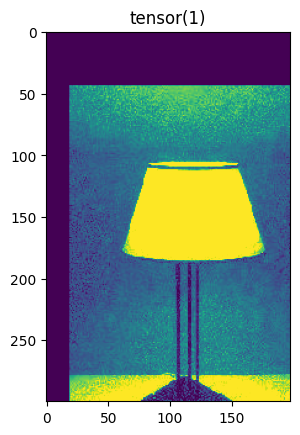

In [142]:
img, target = next(iter(train_loader2))
print(img.shape, target)
plt.imshow(img[0, 0])
plt.title(target[0])

## Models emprats

Explicar models

## Mètriques

Explicar mètriques

# Exercicis i experiments

## Classificació

### Classificació amb AlexNet

Explicació de classificació amb AlexNet

In [153]:
alex = models.alexnet(weights=True)
num_features = alex.classifier[6].in_features
alex.classifier[6] = nn.Linear(num_features, 2)  # 2 clases (binaria)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alex.to(device)

print("Arquitectura AlexNet:")
print(alex)

Arquitectura AlexNet:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_featu

In [8]:
alex.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [154]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.Adam(alex.parameters(), lr=learning_rate)

In [155]:
running_loss = []
running_acc = []

running_test_loss = []
running_test_acc_cnn = []

for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0

    i_batch = 1
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"):
        alex.train()  # Posam el model a mode entranament.

        optimizer.zero_grad()

        # 1. PREDICCIÓ
        y_pred = alex(x.to(device))

        # 2. CALCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        loss = loss_fn(y_pred, y.to(device))

        #3. GRADIENT
        alex.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIO
        with torch.no_grad():
            optimizer.step()

        # 5. EVALUAM EL MODEL
        alex.eval()  # Mode avaluació de la xarxa

        y_pred = alex(x.to(device)).detach().cpu()
        batch_loss += (loss_fn(y_pred, y).detach())

        y_pred_class = torch.argmax(y_pred, dim=1)
        batch_acc += accuracy_score(y, y_pred_class)

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0

    alex.eval()
    for i_batch, (x, y) in enumerate(test_loader):
        y_pred = alex(x.to(device))
        batch_test_loss += (loss_fn(y_pred, y.to(device)).detach())

        y_pred_class = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
        batch_test_acc += accuracy_score(y, y_pred_class)

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    running_test_acc_cnn.append(batch_test_acc / (i_batch + 1))

Èpoques:   0%|          | 0/11 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

Batches (Època 6): 0it [00:00, ?it/s]

Batches (Època 7): 0it [00:00, ?it/s]

Batches (Època 8): 0it [00:00, ?it/s]

Batches (Època 9): 0it [00:00, ?it/s]

Batches (Època 10): 0it [00:00, ?it/s]

Batches (Època 11): 0it [00:00, ?it/s]

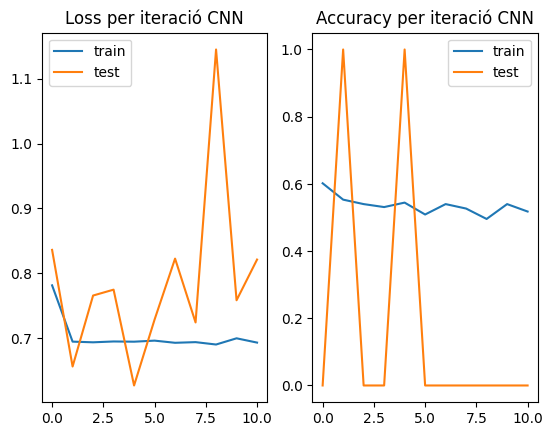

In [156]:
cpu_running_loss = [t.cpu() for t in running_loss]
cpu_running_test_loss = [t.cpu() for t in running_test_loss]
plt.subplot(1,2,1)
plt.title("Loss per iteració CNN")
plt.plot(cpu_running_loss, label="train")
plt.plot(cpu_running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc_cnn, label="test")
plt.legend()
plt.show()

In [150]:
# Inicializar listas para guardar métricas
running_loss = []
running_acc = []

running_test_loss = []
running_test_acc_cnn = []

# Entrenamiento
for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0

    alex.train()  # Modo entrenamiento

    # Iterar sobre los batches de entrenamiento
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})", leave=False):
        x, y = x.to(device), y.to(device)

        # Paso de optimización
        optimizer.zero_grad()

        # 1. Predicción
        y_pred = alex(x)

        # 2. Cálculo de la pérdida
        loss = loss_fn(y_pred, y)

        # 3. Gradientes
        loss.backward()

        # 4. Optimización
        optimizer.step()

        # Actualizar métricas del batch
        batch_loss += loss.item()
        y_pred_class = torch.argmax(y_pred, dim=1)
        batch_acc += (y_pred_class == y).sum().item() / y.size(0)

    # Guardar métricas de la época
    running_loss.append(batch_loss / len(train_loader))
    running_acc.append(batch_acc / len(train_loader))

    # Validación (test)
    batch_test_loss = 0
    batch_test_acc = 0

    alex.eval()  # Modo evaluación
    with torch.no_grad():
        for i_batch, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)

            # 1. Predicción
            y_pred = alex(x)

            # 2. Cálculo de la pérdida
            loss = loss_fn(y_pred, y)
            batch_test_loss += loss.item()

            # 3. Métrica de exactitud
            y_pred_class = torch.argmax(y_pred, dim=1)
            batch_test_acc += (y_pred_class == y).sum().item() / y.size(0)

    running_test_loss.append(batch_test_loss / len(test_loader))
    running_test_acc_cnn.append(batch_test_acc / len(test_loader))

Èpoques:   0%|          | 0/15 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

Batches (Època 6): 0it [00:00, ?it/s]

Batches (Època 7): 0it [00:00, ?it/s]

Batches (Època 8): 0it [00:00, ?it/s]

Batches (Època 9): 0it [00:00, ?it/s]

Batches (Època 10): 0it [00:00, ?it/s]

Batches (Època 11): 0it [00:00, ?it/s]

Batches (Època 12): 0it [00:00, ?it/s]

Batches (Època 13): 0it [00:00, ?it/s]

Batches (Època 14): 0it [00:00, ?it/s]

Batches (Època 15): 0it [00:00, ?it/s]

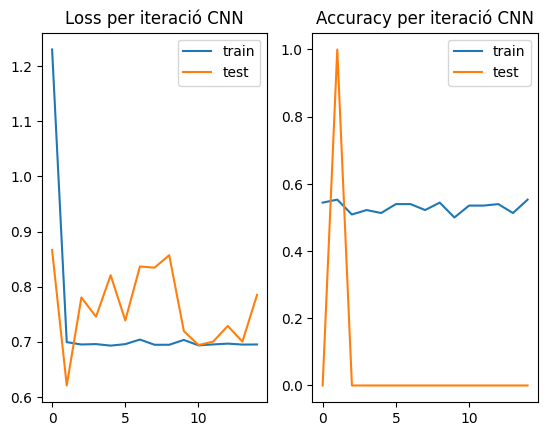

In [151]:
plt.subplot(1,2,1)
plt.title("Loss per iteració CNN")
plt.plot(running_loss, label="train")
plt.plot(running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc_cnn, label="test")
plt.legend()
plt.show()